In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gzip, sys
from itertools import islice
from Bio.Seq import Seq
from itertools import zip_longest
from Bio import SeqIO
import gzip

In [5]:
amplicon_index_df = pd.read_excel('Petri-seq All First 24 Barcoded Oligos.xlsx',header=1)

amplicon_index_df = [w for w in amplicon_index_df['Index'].tolist() if not pd.isna(w)]
amplicon_index_df = [w for w in amplicon_index_df if 'A' in w or 'T' in w or 'C' in w or 'G' in w]

# invariant primer segments that precede each 6-nt barcode
PREFIX_R1 = "GCCAGAC"    # Round-1 RT primer
PREFIX_R2 = "GCTTCGC"    # Round-2 ligation oligo
PREFIX_R3 = "AGGTCCTTG"    # Round-2 ligation oligo

ROUND1 = amplicon_index_df[0:24]
ROUND2 = amplicon_index_df[24:48]
ROUND3 = amplicon_index_df[48:72]

In [6]:
# def open_fastq(path):
#     """Open FASTQ or FASTQ.gz in text mode."""
#     return gzip.open(path, "rt") if str(path).endswith(".gz") else open(path)

# def has_barcode(seq,prefix,choices,br,offset=0,size=6, max_mismatch=0):

#     start = seq.find(prefix)
#     if start == -1:
#         return False
#     window = seq[start + len(prefix) + offset : start + len(prefix) + offset + size]
#     if(br==3):
#         window = seq[start-6:start]
#     if len(window) < size:
#         return False
#     if window in choices:
#         return True
#     if max_mismatch:                    # allow Hamming-1 or Hamming-n
#         return any(
#             sum(a != b for a, b in zip(window, bc)) <= max_mismatch
#             for bc in choices
#         )
#     return False

In [7]:
# fast reverse complement (no Biopython import needed)
_RC = str.maketrans("ACGTNacgtn", "TGCANtgcan")
def _revcomp(s: str) -> str:
    return s.translate(_RC)[::-1]

def _has_barcode_one_strand(seq, prefix, choices, br, offset=0, size=6, max_mismatch=0):
    # find prefix on this strand
    start = seq.find(prefix)
    if start == -1:
        return False

    # choose window relative to prefix
    if br == 3:
        # barcode is upstream of prefix
        if start < size:
            return False
        window = seq[start - size : start]
    else:
        # barcode is downstream of prefix (+ optional offset)
        i = start + len(prefix) + offset
        window = seq[i : i + size]

    if len(window) < size:
        return False

    # exact match first
    if window in choices:
        return True

    # allow mismatches by Hamming distance if requested
    if max_mismatch:
        return any(sum(a != b for a, b in zip(window, bc)) <= max_mismatch for bc in choices)

    return False

def has_barcode(seq, prefix, choices, br, offset=0, size=6, max_mismatch=0):
    # normalize to uppercase once
    seq = seq.upper()
    prefix = str(prefix).upper()
    # ensure choices are uppercase (set or list both fine)
    if choices and isinstance(next(iter(choices)), str):
        choices_uc = {c.upper() for c in choices}
    else:
        choices_uc = choices

    # try forward strand
    if _has_barcode_one_strand(seq, prefix, choices_uc, br, offset, size, max_mismatch):
        return True

    # try reverse-complement strand
    rc_seq = _revcomp(seq)
    return _has_barcode_one_strand(rc_seq, prefix, choices_uc, br, offset, size, max_mismatch)

In [8]:
def _open_seq_iter(path):
    """
    Return an iterator of SeqRecord objects from a FASTQ or FASTQ.gz file.
    """
    handle = gzip.open(path, "rt") if str(path).endswith(".gz") else open(path, "rt")
    # SeqIO.parse() returns a generator; no entire file is loaded into memory.
    return SeqIO.parse(handle, "fastq"), handle   # also return handle so we can close it


def count_pair(fq1, fq2, *, max_mismatch=0):
    """
    Count read-pairs that contain each of the three inline barcodes.
    A pair is positive for a barcode if **either** mate has it.
    """
    it1, h1 = _open_seq_iter(fq1)
    it2, h2 = _open_seq_iter(fq2)

    total = r1 = r2 = r3 = all3 = 0

    for rec1, rec2 in zip_longest(it1, it2):
        if rec1 is None or rec2 is None:           # unequal file lengths
            break

        total += 1
        s1, s2 = str(rec1.seq).upper(), str(rec2.seq).upper()

        hit1 = (has_barcode(s1, PREFIX_R1, ROUND1,br=1, max_mismatch=max_mismatch) or
                has_barcode(s2, PREFIX_R1, ROUND1,br=1, max_mismatch=max_mismatch))
        
        hit2 = (has_barcode(s1, PREFIX_R2, ROUND2,br=2, max_mismatch=max_mismatch) or
                has_barcode(s2, PREFIX_R2, ROUND2,br=2, max_mismatch=max_mismatch))
        
        hit3 = (has_barcode(s1, PREFIX_R3, ROUND3,br=3, max_mismatch=max_mismatch) or
                has_barcode(s2, PREFIX_R3, ROUND3,br=3, max_mismatch=max_mismatch))

        r1 += hit1
        r2 += hit2
        r3 += hit3
        all3 += hit1 and hit2 and hit3

    h1.close(); h2.close()
    pct = 100 * all3 / total if total else 0.0
    return dict(
        total_reads     = total,
        with_r1         = r1,
        with_r2         = r2,
        with_r3         = r3,
        with_all_three  = all3,
        pct_all_three   = pct,
    )

In [9]:
### ------------------------------------------------------------------
### 4. Manifest – map samples & replicates to FASTQ paths
### ------------------------------------------------------------------
# Edit this block to match your file names / folder layout.
manifest = {
    "Lib1": {
        "rep1": {"R1": "RNA_seq_reads/PAL063_R1.fastq.gz",
                 "R2": "RNA_seq_reads/PAL063_R2.fastq.gz"},

    },
    "Lib2_riborid": {
        "rep1": {"R1": "RNA_seq_reads/PAL064_R1.fastq.gz",
                 "R2": "RNA_seq_reads/PAL064_R2.fastq.gz"},
    }}
rows = []
for sample, reps in manifest.items():
    for rep, files in reps.items():
        stats = count_pair(files["R1"], files["R2"])
        stats.update(sample=sample, replicate=rep)
        rows.append(stats)

rep_df = pd.DataFrame(rows)
rep_df

,total_reads,with_r1,with_r2,with_r3,with_all_three,pct_all_three,sample,replicate
0,43154664,20427636,14807053,10772006,9386580,21.751021,Lib1,rep1
1,61514503,11070567,10566480,8169224,5180999,8.422402,Lib2_riborid,rep1


In [10]:
### ------------------------------------------------------------------
### 6. Aggregate results per sample
### ------------------------------------------------------------------
agg = (
    rep_df.groupby("sample")
          .sum(numeric_only=True)
          .assign(pct_all_three=lambda d: 100 * d["with_all_three"] / d["total_reads"])
)

agg[["total_reads", "with_all_three", "pct_all_three"]]

,total_reads,with_all_three,pct_all_three
sample,,,
Lib1,43154664,9386580,21.751021
Lib2_riborid,61514503,5180999,8.422402


In [14]:
rep_df['Index_1_%'] = [100*w['with_r1']/w['total_reads'] for _,w in rep_df.iterrows()]
rep_df['Index_2_%'] = [100*w['with_r2']/w['total_reads'] for _,w in rep_df.iterrows()]
rep_df['Index_3_%'] = [100*w['with_r3']/w['total_reads'] for _,w in rep_df.iterrows()]
rep_df['All_Index_%'] = [100*w['with_all_three']/w['total_reads'] for _,w in rep_df.iterrows()]

rep_df


,total_reads,with_r1,with_r2,with_r3,with_all_three,pct_all_three,sample,replicate,Index_1_%,Index_2_%,Index_3_%,All_Index_%
0,43154664,20427636,14807053,10772006,9386580,21.751021,Lib1,rep1,47.335871,34.311594,24.961395,21.751021
1,61514503,11070567,10566480,8169224,5180999,8.422402,Lib2_riborid,rep1,17.996678,17.177218,13.280159,8.422402


([<matplotlib.axis.XTick at 0x7fc4a58b58e0>,
 [Text(0, 0, 'Lib1'), Text(1, 0, 'Lib2_riborid')])

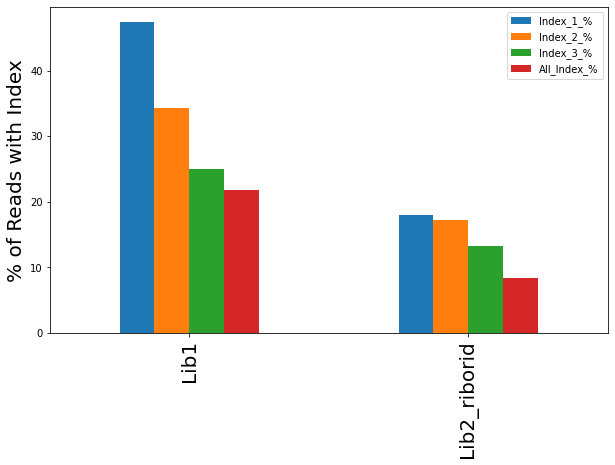

In [27]:
#import matplotlib.pyplot as plt  # re-imports and resets xticks

rep_df[['Index_1_%', 'Index_2_%', 'Index_3_%', 'All_Index_%']].plot.bar(stacked=False, figsize=(10, 6))
plt.ylabel('% of Reads with Index',fontsize=20)
plt.xticks(ticks=range(len(rep_df['sample'])), labels=rep_df['sample'], fontsize=20)

In [25]:
import importlib
import matplotlib.pyplot as plt
importlib.reload(plt)

<module 'matplotlib.pyplot' from '/home/kkrishnan/.local/lib/python3.8/site-packages/matplotlib/pyplot.py'>